In [1]:
from google2pandas import GoogleAnalyticsQueryV4
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### establish google analytics connection and download all scroll data for Attention site

In [2]:
conn = GoogleAnalyticsQueryV4(secrets='attention_service_credentials.json')

In [15]:
scroll_query = {
    'reportRequests': [{
        'viewId' : '187999039',
        
        'dateRanges': [{
            'startDate' : '2019-01-26',
            'endDate'   : '2020-05-01'}],

        'dimensions' : [
            {'name' : 'ga:eventCategory'},
            {'name' : 'ga:eventAction'},
            {'name' : 'ga:eventLabel'},
            {'name' : 'ga:pagePath'},
            {'name' : 'ga:pageTitle'},
            {'name' : 'ga:dateHourMinute'}],

        'metrics'   : [
            {'expression' : 'ga:totalEvents'}],
    }]
}

df_scrolls = conn.execute_query(scroll_query)

### cleaning scroll data and connecting user ids using google client

In [16]:
df_scrolls['scroll_depth'] = pd.to_numeric(df_scrolls['eventAction'].str[:-1])
df_scrolls[['content_version','local_id','google_id']] = df_scrolls['eventLabel'].str.split(':',expand=True)

id_mapper = df_scrolls.loc[df_scrolls['google_id']!='false',['local_id','google_id']].drop_duplicates()
id_mapper.columns = ['local_id','user_id']
df_scrolls = df_scrolls.merge(id_mapper,how='left',on='local_id')

df_scrolls.loc[df_scrolls['user_id'].isnull(),'user_id'] = df_scrolls.loc[df_scrolls['user_id'].isnull(),'local_id']

df_scrolls['timestamp'] = pd.to_datetime(df_scrolls['dateHourMinute'],format='%Y%m%d%H%M')

## graph of user read completion over time

Text(0, 0.5, 'percent completion')

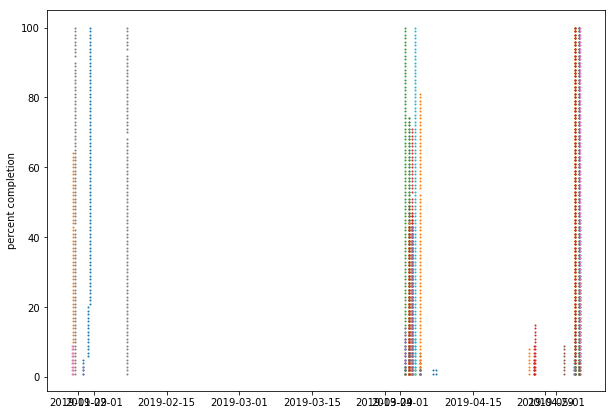

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
for name, group in df_scrolls.groupby("user_id"):
    ax.plot(group['timestamp'], group['scroll_depth'], marker='o', linestyle='', ms=1, label=name)
# ax.legend()
plt.ylabel('percent completion')

### remove large gaps between reading session to get contiguous reading rate

In [18]:
df = df_scrolls[['user_id','timestamp','scroll_depth','pagePath','content_version']].copy()
df['relative_time_hours']=df.groupby('user_id')['timestamp'].apply(lambda x: (x-min(x)).map(lambda y: y.total_seconds()/3600))
df = df.sort_values(['user_id','relative_time_hours'])
df['time_diff'] = df['relative_time_hours'].diff()
df.loc[df['user_id']!=df['user_id'].shift(),'time_diff']=None
df.loc[df['time_diff']<1,'time_diff']=0
df['cumulative_gap_time'] = df[['user_id','relative_time_hours','time_diff']].groupby('user_id')['time_diff'].apply(lambda x: x.cumsum())
df['relative_time_no_gaps']=df['relative_time_hours']-df['cumulative_gap_time']

In [19]:
df['user_id'].value_counts()

351800151.1554352977     564
1288184274.1547962584    371
302217108.1557009034     299
710549500.1557009136     202
631855005.1554354418     198
245359556.1548688664     196
1030982381.1548824537    100
aOhINrRsewWmljX3boKg     100
1239958419.1554177423    100
IND0MsxkOLKqn7DZx1Cg     100
P9gpLHm8STnHL0D7qDWY      74
TF5sXwrQzRAKfjIGPxeQ      73
1216800838.1548651330     64
ZdGP4CMxwSC65EID064J      44
gA9AUaa4qJlnrl66Ad7v      44
D7AFwRB2es2k9pwZK3ds      43
gsNmf1Q0fkxdqmmgGypt      43
wbOsfVItSOsVCybzJMm3      43
GeyJ6MbXVU98vMoCuJqj      43
JgHlXcIfT7GKbOh7CvEU      43
rJzaZWd1l3ojvrH3EZUe      43
SKkTLV4ahu7aNJsBqDu7      43
PWUfNihrbLV1oZDPhFdX      42
FbAVXSzLkLvU8WGUspFl      42
JPCDwLAXbxyRNef931L1      38
1602514368.1550182957     32
DMNSVLgbiHI9vnv4qQ2x      28
2032727617.1547529710      9
HuSerufhdx90QqdWAGOL       9
1812197314.1556823552      9
vERe8mFAUOHozXxPdZte       4
eghVupw5nNz6AqNlrffC       4
cNTeLR7HM2cx2p7egRgj       4
TuNvIPqR49rusJQCvhod       4
8lOctux5m7othP

## user overall read time combining sessions
dots represent session breaks

(-0.01, 0.9)

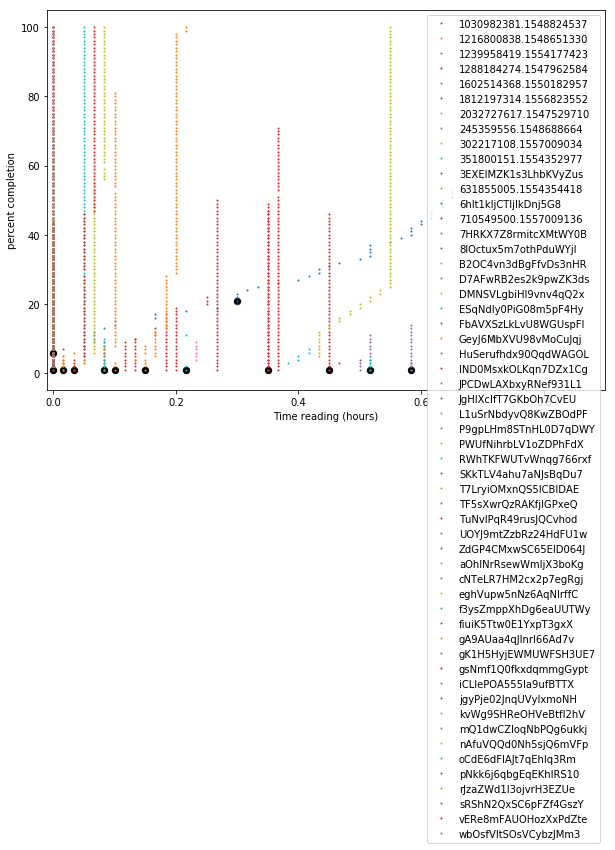

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
# df.groupby("user_id").plot.scatter(x="relative_time_no_gaps", y="scroll_depth", ax=ax)
for name, group in df.groupby("user_id"):
    ax.plot(group['relative_time_no_gaps'], group['scroll_depth'], marker='o', linestyle='', ms=1, label=name)

df.loc[df['time_diff']>0].plot.scatter(x="relative_time_no_gaps", y="scroll_depth", marker="o", c='black', s=40, ax=ax)
ax.legend(df['user_id'].unique().tolist())
plt.ylabel('percent completion')
plt.xlabel('Time reading (hours)')
plt.xlim(-0.01,0.9)

Text(0, 0.5, 'percent completion')

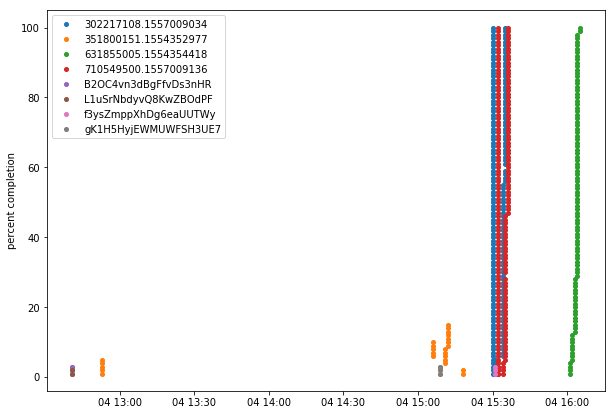

In [28]:


fig, ax = plt.subplots(figsize=(10,7))
for name, group in df_scrolls.loc[(df_scrolls['timestamp']>'2019-05-04') & (df_scrolls['timestamp']<'2019-05-05')].groupby("user_id"):
    ax.plot(group['timestamp'], group['scroll_depth'], marker='o', linestyle='', ms=4, label=name)
ax.legend()
plt.ylabel('percent completion')